In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
import scipy
from PIL import Image
from scipy import ndimage

In [ ]:
# Loading Dataset from a h5 file.
train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
training_set_x = np.array(train_dataset["train_set_x"][:]) # your train set features
training_set_y = np.array(train_dataset["train_set_y"][:]) # your train set labels

test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
test_set_x = np.array(test_dataset["test_set_x"][:]) # your test set features
test_set_y = np.array(test_dataset["test_set_y"][:]) # your test set labels

classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
training_set_y = training_set_y.reshape((1, training_set_y.shape[0]))
test_set_y = test_set_y.reshape((1, test_set_y.shape[0]))
    
   

In [ ]:
# Example of a picture
index = 1
plt.imshow(train_set_x_orig[index])

print ("y = " + str(training_set_y[:, index]) + ", it's a '" + classes[np.squeeze(training_set_y[:, index])].decode("utf-8") +  "' picture.")

In [ ]:
training_set_x.shape

Training_set_x and test_set_x are numpy arrays of shape(m, num_px, num_px, 3).
Square Images with 3 Channels RGB.

In [ ]:
# Getting the number of training examples.
# Stored as first dimension of  training_set_x numpy array
m_train = training_set_x.shape[0]

# Getting the number of test set examples.
m_test= test_set_x.shape[0]

num_px = training_set_x.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(training_set_x.shape))
print ("train_set_y shape: " + str(training_set_y.shape))
print ("test_set_x shape: " + str(test_set_x.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

In [ ]:
# Reshaping the arrays.
# Each Column of new matrix represent an example. First nx*nx pixels are Red Channel pixels followed by nx*nx Green Channel pixels followed by Blue Channel pixels.

training_set_x_flatten=training_set_x.reshape(train_set_x_orig.shape[0],-1).T

test_set_x_flatten = test_set_x.reshape(test_set_x.shape[0],-1).T


print ("training_set_x_flatten shape: " + str(training_set_x_flatten.shape))
print ("training_set_y shape: " + str(training_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))


In [ ]:
# Preprocessing the data. Standardize the dataset i.e. features x.
# Divide value of ech pixel by 255.
training_set_x = training_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

In [ ]:
# Sigmoid Activation Function:
# Input is any scalar or a numpy array.
def sigmoid(z):
    """
    Find the sigmoid of z
    Input:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    
    a=np.exp(-z)
    b=1+a
    s=1/b
   
    return s

In [ ]:
# Initializing the parameters.
def initialize_params(dimension):
    w=np.zeros((dimension,1))
    b=0
    
    return w,b

In [ ]:
# Forward And Backward Propagation:

def propagate(w, b, X, Y):
    """
    Input :
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    """
    
    m = X.shape[1]
    
    # Forward Propagation to compute the cost.

    wx= np.dot(w.T,X)
    z=wx+b
    A=sigmoid(z)
    # A is a row vector of shape (1,m) having activations of all the examples. 
    
    # Calculating the total cost wrt all examples using A(activations) and Y(labels).
    cost=(-1/m)*(np.sum(np.multiply(np.log(A),Y))+np.sum( np.multiply(1-Y,np.log(1-A))))
    
    
    # Back propagation to find gradients of cost wrt w and b.
 
    
    # Using chain rule, we find that dz is the difference of activation and original label.
    # dz is a row vector having gradient wrt z for all examples.
    dz=A-Y
    
    # Again using chain rule, we can find that gradient w.r.t parameters dw1= x1 * dz.
    # We need  to sum up dw1 wrt all examples. And similarly for w2,...wn, where n is the number of features.
    # dw is column vector where first element is dw1, second element is dw2 and so on.
    dw=1/m* (np.dot(X,dz.T))
    
    # Using chain rule, we can find that db = 1* dz. 
    # We need to sum up b wrt all examples.
    db=1/m*(np.sum(dz))
   
   # Storing the gradients in a dictionary. 
    grads = {"dw": dw,
             "db": db}
   
    return grads, cost

In [ ]:
# Optimizing the cost using Gradient Descent.

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    """
    
    costs = []
    
    for i in range(num_iterations):
       
        # Finding cost and gradients by calliing the above function propagate().
        grads, cost=propagate(w,b,X,Y)
        
        
        # Retrieve gradients from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # Updating the values of w(vector) and b.
        w=w-(learning_rate)*dw
              
        b=b-(learning_rate)*db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [ ]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Computing vector "A" predicting the probabilities of a cat being present in the picture
   
    A = sigmoid(np.dot(w.T,X) +b)
      
    for i in range(A.shape[1]):
        
        # Converting probabilities A[0,i] to actual predictions p[0,i]
        # Taking threshold as 0.5
        if(A[0][i]<=0.5):
            Y_prediction[0][i]=0
            
        else:
            Y_prediction[0][i]=1
        pass
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [ ]:
#  Building the model.
def log_reg_model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function  implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
   
    
    # initializing the  parameters with zeros 
   
    w=np.zeros((X_train.shape[0],1))
    b=0

    # Gradient descent. 
    # Forward and back propagate are called inside the optimize function.
    parameters, grads, costs = optimize(w,b,X_train,Y_train,num_iterations,learning_rate,print_cost=True)
    
    # Retrieving parameters w and b from dictionary "parameters"
    # These are the trained values of w and b.
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w,b,X_test)
    Y_prediction_train = predict(w,b,X_train)


    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [ ]:
d = log_reg_model(training_set_x, training_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

In [ ]:
# Example of a picture that was wrongly classified.
index = 1
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[d["Y_prediction_test"][0,index]].decode("utf-8") +  "\" picture.")

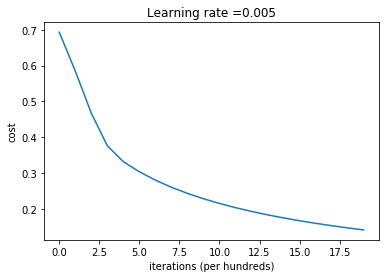

In [38]:
# Plotting the cost wrt number of iterations.

costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

learning rate is: 0.01
Cost after iteration 0: 0.693147
Cost after iteration 100: 0.823921
Cost after iteration 200: 0.418944
Cost after iteration 300: 0.617350
Cost after iteration 400: 0.522116
Cost after iteration 500: 0.387709
Cost after iteration 600: 0.236254
Cost after iteration 700: 0.154222
Cost after iteration 800: 0.135328
Cost after iteration 900: 0.124971
Cost after iteration 1000: 0.116478
Cost after iteration 1100: 0.109193
Cost after iteration 1200: 0.102804
Cost after iteration 1300: 0.097130
Cost after iteration 1400: 0.092043
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
Cost after iteration 0: 0.693147
Cost after iteration 100: 0.591289
Cost after iteration 200: 0.555796
Cost after iteration 300: 0.528977
Cost after iteration 400: 0.506881
Cost after iteration 500: 0.487880
Cost after iteration 600: 0.471108
Cost after iteration 700: 0.456046
Cost after iteration 800: 0.442

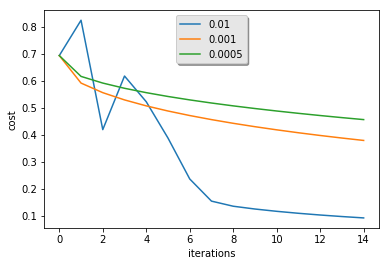

In [41]:
# traing models for different values of learning rates.
learning_rates = [0.01, 0.001, 0.0005]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = log_reg_model(training_set_x, training_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()